In [1]:
import torch
import numpy as np
import random
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import pandas
import time

###  读取数据集

In [2]:
## 划分数据集
def sliding_window(seq,window_size):
    result=[]
    for i in range(len(seq)-window_size):
        result.append(seq[i:i+window_size])
    return result

data=np.load("./pems-traffic-flow/PEMS04.npz")  # npz是二进制格式

data=data["data"][:,0:1,0:1]
# data
## 归一化
dmin,dmax=data.min(),data.max()
data=(data-dmin)/(dmax-dmin)
sensordata_num,sensor_num,_ = data.shape  
# print(data.shape)  #(16992,1,1)

train_set,test_set = [],[]  
for  i in range(sensor_num) :  
    train_seq = data[:int(sensordata_num*0.8),i,:]  
    test_seq = data[int(sensordata_num*0.8):,i,:]  
    train_set += sliding_window(train_seq,window_size=13)  
    test_set += sliding_window(test_seq,window_size=13)  
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()  
# print(train_set.shape,test_set.shape)    #（13580,13)
# print(train_set,test_set)                #(3386,13)

### 初始化模型+优化器

In [3]:
device = 'cpu'  
torch_gru = nn.GRU(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
output_model = nn.Linear(32, 1)
loss_func = nn.MSELoss()  
optimizer = torch.optim.Adam(list(torch_gru.parameters()) + list(output_model.parameters()), lr=0.0001)

### mape函数

In [4]:
def mape(y_true, y_pred):  
    y_true, y_pred = np.array(y_true), np.array(y_pred)  
    non_zero_index = (y_true > 0)  
    y_true = y_true[non_zero_index]  
    y_pred = y_pred[non_zero_index]  
  
    mape = np.abs((y_true - y_pred) / y_true)  
    mape[np.isinf(mape)] = 0  
    return np.mean(mape) * 100  

### next_batch函数

In [5]:
def next_batch(data, batch_size):  
    data_length = len(data)  
    num_batches = math.ceil(data_length / batch_size)  
    for batch_index in range(num_batches):  
        start_index = batch_index * batch_size  
        end_index = min((batch_index + 1) * batch_size, data_length)  
        yield data[start_index:end_index]

### 开始训练

In [6]:
from sklearn.utils import shuffle 
import math 
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image 
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [7]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        out, hidden = torch_gru(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = output_model(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        #total_1oss += loss.item( )
        trained_batches += 1
         #计算平均oss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                out, hidden = torch_gru(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = output_model(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))

batch 1, train_loss 0.140111,Time used 0.039893s
batch 2, train_loss 0.165527,Time used 0.007980s
batch 3, train_loss 0.149710,Time used 0.006982s
batch 4, train_loss 0.159514,Time used 0.007980s
batch 5, train_loss 0.137537,Time used 0.008976s
batch 6, train_loss 0.147494,Time used 0.007980s
batch 7, train_loss 0.136216,Time used 0.006982s
batch 8, train_loss 0.144735,Time used 0.006982s
batch 9, train_loss 0.144682,Time used 0.006981s
batch 10, train_loss 0.125011,Time used 0.008975s
batch 11, train_loss 0.174294,Time used 0.006981s
batch 12, train_loss 0.143316,Time used 0.006982s
batch 13, train_loss 0.152435,Time used 0.006981s
batch 14, train_loss 0.158054,Time used 0.007979s
batch 15, train_loss 0.136167,Time used 0.006982s
batch 16, train_loss 0.121763,Time used 0.006982s
batch 17, train_loss 0.142193,Time used 0.006981s
batch 18, train_loss 0.132170,Time used 0.007980s
batch 19, train_loss 0.129189,Time used 0.008976s
batch 20, train_loss 0.134574,Time used 0.008976s
batch 21,

batch 161, train_loss 0.054585,Time used 0.006982s
batch 162, train_loss 0.060856,Time used 0.006982s
batch 163, train_loss 0.054123,Time used 0.006981s
batch 164, train_loss 0.061414,Time used 0.006982s
batch 165, train_loss 0.062260,Time used 0.006982s
batch 166, train_loss 0.050544,Time used 0.005984s
batch 167, train_loss 0.057156,Time used 0.006981s
batch 168, train_loss 0.063452,Time used 0.006982s
batch 169, train_loss 0.060564,Time used 0.006982s
batch 170, train_loss 0.061385,Time used 0.006981s
batch 171, train_loss 0.057176,Time used 0.006981s
batch 172, train_loss 0.051769,Time used 0.007979s
batch 173, train_loss 0.045570,Time used 0.007978s
batch 174, train_loss 0.058487,Time used 0.006982s
batch 175, train_loss 0.046831,Time used 0.005984s
batch 176, train_loss 0.052950,Time used 0.007979s
batch 177, train_loss 0.061246,Time used 0.007978s
batch 178, train_loss 0.047063,Time used 0.006982s
batch 179, train_loss 0.052881,Time used 0.006982s
batch 180, train_loss 0.052976,

batch 316, train_loss 0.039502,Time used 0.007979s
batch 317, train_loss 0.030107,Time used 0.007979s
batch 318, train_loss 0.037441,Time used 0.007978s
batch 319, train_loss 0.044097,Time used 0.006982s
batch 320, train_loss 0.042926,Time used 0.006981s
batch 321, train_loss 0.038270,Time used 0.004987s
batch 322, train_loss 0.037735,Time used 0.009973s
batch 323, train_loss 0.036135,Time used 0.006982s
batch 324, train_loss 0.038679,Time used 0.006982s
batch 325, train_loss 0.035997,Time used 0.007978s
batch 326, train_loss 0.042756,Time used 0.008976s
batch 327, train_loss 0.032335,Time used 0.025931s
batch 328, train_loss 0.040694,Time used 0.009973s
batch 329, train_loss 0.040359,Time used 0.011967s
batch 330, train_loss 0.036591,Time used 0.008976s
batch 331, train_loss 0.041498,Time used 0.006981s
batch 332, train_loss 0.041315,Time used 0.008977s
batch 333, train_loss 0.037137,Time used 0.009972s
batch 334, train_loss 0.040542,Time used 0.008977s
batch 335, train_loss 0.036393,

batch 473, train_loss 0.034242,Time used 0.008976s
batch 474, train_loss 0.029479,Time used 0.007980s
batch 475, train_loss 0.031299,Time used 0.007978s
batch 476, train_loss 0.028452,Time used 0.006981s
batch 477, train_loss 0.027677,Time used 0.006981s
batch 478, train_loss 0.030345,Time used 0.007979s
batch 479, train_loss 0.032375,Time used 0.006981s
batch 480, train_loss 0.030472,Time used 0.006982s
batch 481, train_loss 0.029334,Time used 0.008976s
batch 482, train_loss 0.028932,Time used 0.008976s
batch 483, train_loss 0.030641,Time used 0.006982s
batch 484, train_loss 0.033278,Time used 0.006981s
batch 485, train_loss 0.027740,Time used 0.007979s
batch 486, train_loss 0.032778,Time used 0.006981s
batch 487, train_loss 0.029748,Time used 0.008975s
batch 488, train_loss 0.033427,Time used 0.006981s
batch 489, train_loss 0.028497,Time used 0.007979s
batch 490, train_loss 0.027234,Time used 0.007979s
batch 491, train_loss 0.028766,Time used 0.006981s
batch 492, train_loss 0.031107,

batch 628, train_loss 0.018687,Time used 0.007978s
batch 629, train_loss 0.022117,Time used 0.006981s
batch 630, train_loss 0.018396,Time used 0.006982s
batch 631, train_loss 0.020439,Time used 0.006981s
batch 632, train_loss 0.017124,Time used 0.007978s
batch 633, train_loss 0.018355,Time used 0.006981s
batch 634, train_loss 0.015544,Time used 0.006981s
batch 635, train_loss 0.020434,Time used 0.006982s
batch 636, train_loss 0.020345,Time used 0.006981s
batch 637, train_loss 0.016427,Time used 0.006981s
batch 638, train_loss 0.016747,Time used 0.006982s
batch 639, train_loss 0.016589,Time used 0.006981s
batch 640, train_loss 0.017183,Time used 0.006982s
batch 641, train_loss 0.017286,Time used 0.006981s
batch 642, train_loss 0.014180,Time used 0.004987s
batch 643, train_loss 0.016168,Time used 0.006981s
batch 644, train_loss 0.017297,Time used 0.007979s
batch 645, train_loss 0.014701,Time used 0.010970s
batch 646, train_loss 0.020991,Time used 0.007978s
batch 647, train_loss 0.018802,

batch 786, train_loss 0.005403,Time used 0.006982s
batch 787, train_loss 0.006056,Time used 0.006980s
batch 788, train_loss 0.007299,Time used 0.006981s
batch 789, train_loss 0.006394,Time used 0.006982s
batch 790, train_loss 0.008430,Time used 0.006981s
batch 791, train_loss 0.006072,Time used 0.010971s
batch 792, train_loss 0.005437,Time used 0.014960s
batch 793, train_loss 0.004824,Time used 0.016955s
batch 794, train_loss 0.006100,Time used 0.020944s
batch 795, train_loss 0.005845,Time used 0.021942s
batch 796, train_loss 0.006155,Time used 0.017951s
batch 797, train_loss 0.006226,Time used 0.014960s
batch 798, train_loss 0.006595,Time used 0.019947s
batch 799, train_loss 0.007726,Time used 0.006981s
batch 800, train_loss 0.006433,Time used 0.009974s
***************************test_batch 800, test_rmse_loss 0.076879,test_mae_loss 0.061891,test_mape_loss 33.157308,Time used 0.070810s
batch 801, train_loss 0.006279,Time used 0.006982s
batch 802, train_loss 0.005905,Time used 0.007978

batch 941, train_loss 0.006345,Time used 0.007979s
batch 942, train_loss 0.004190,Time used 0.008976s
batch 943, train_loss 0.005307,Time used 0.008976s
batch 944, train_loss 0.004623,Time used 0.007979s
batch 945, train_loss 0.003963,Time used 0.008976s
batch 946, train_loss 0.004640,Time used 0.008976s
batch 947, train_loss 0.005847,Time used 0.008977s
batch 948, train_loss 0.005668,Time used 0.007978s
batch 949, train_loss 0.004862,Time used 0.007979s
batch 950, train_loss 0.005169,Time used 0.007981s
batch 951, train_loss 0.005747,Time used 0.008976s
batch 952, train_loss 0.005067,Time used 0.006981s
batch 953, train_loss 0.004876,Time used 0.008977s
batch 954, train_loss 0.003894,Time used 0.007978s
batch 955, train_loss 0.003933,Time used 0.007979s
batch 956, train_loss 0.003402,Time used 0.008977s
batch 957, train_loss 0.004550,Time used 0.008976s
batch 958, train_loss 0.003954,Time used 0.007979s
batch 959, train_loss 0.004717,Time used 0.007980s
batch 960, train_loss 0.004501,

batch 1097, train_loss 0.003148,Time used 0.008977s
batch 1098, train_loss 0.002972,Time used 0.007979s
batch 1099, train_loss 0.004265,Time used 0.007978s
batch 1100, train_loss 0.003796,Time used 0.007980s
***************************test_batch 1100, test_rmse_loss 0.067334,test_mae_loss 0.050070,test_mape_loss 18.425084,Time used 0.077792s
batch 1101, train_loss 0.005067,Time used 0.007979s
batch 1102, train_loss 0.003542,Time used 0.008976s
batch 1103, train_loss 0.004436,Time used 0.008976s
batch 1104, train_loss 0.005562,Time used 0.007979s
batch 1105, train_loss 0.004187,Time used 0.008976s
batch 1106, train_loss 0.005092,Time used 0.007979s
batch 1107, train_loss 0.004090,Time used 0.007978s
batch 1108, train_loss 0.003000,Time used 0.008977s
batch 1109, train_loss 0.004301,Time used 0.007979s
batch 1110, train_loss 0.003661,Time used 0.007979s
batch 1111, train_loss 0.004213,Time used 0.011968s
batch 1112, train_loss 0.003956,Time used 0.007978s
batch 1113, train_loss 0.003504,

batch 1249, train_loss 0.005075,Time used 0.006982s
batch 1250, train_loss 0.005939,Time used 0.006982s
batch 1251, train_loss 0.005022,Time used 0.006982s
batch 1252, train_loss 0.003098,Time used 0.009972s
batch 1253, train_loss 0.004413,Time used 0.006981s
batch 1254, train_loss 0.004169,Time used 0.007978s
batch 1255, train_loss 0.004718,Time used 0.005984s
batch 1256, train_loss 0.003456,Time used 0.007979s
batch 1257, train_loss 0.005409,Time used 0.006981s
batch 1258, train_loss 0.003581,Time used 0.006982s
batch 1259, train_loss 0.003102,Time used 0.006981s
batch 1260, train_loss 0.005648,Time used 0.006982s
batch 1261, train_loss 0.003358,Time used 0.007979s
batch 1262, train_loss 0.006639,Time used 0.006982s
batch 1263, train_loss 0.003068,Time used 0.006982s
batch 1264, train_loss 0.004048,Time used 0.006981s
batch 1265, train_loss 0.004060,Time used 0.006981s
batch 1266, train_loss 0.004015,Time used 0.006981s
batch 1267, train_loss 0.005264,Time used 0.007979s
batch 1268, 

batch 1401, train_loss 0.003282,Time used 0.005984s
batch 1402, train_loss 0.004178,Time used 0.006982s
batch 1403, train_loss 0.003910,Time used 0.008978s
batch 1404, train_loss 0.004399,Time used 0.007979s
batch 1405, train_loss 0.004649,Time used 0.006982s
batch 1406, train_loss 0.004385,Time used 0.006982s
batch 1407, train_loss 0.004572,Time used 0.007978s
batch 1408, train_loss 0.003624,Time used 0.006982s
batch 1409, train_loss 0.004840,Time used 0.007980s
batch 1410, train_loss 0.004940,Time used 0.005985s
batch 1411, train_loss 0.003544,Time used 0.006981s
batch 1412, train_loss 0.003976,Time used 0.006981s
batch 1413, train_loss 0.004753,Time used 0.006982s
batch 1414, train_loss 0.004214,Time used 0.007980s
batch 1415, train_loss 0.003462,Time used 0.006982s
batch 1416, train_loss 0.003547,Time used 0.006981s
batch 1417, train_loss 0.004282,Time used 0.008976s
batch 1418, train_loss 0.004642,Time used 0.006981s
batch 1419, train_loss 0.003923,Time used 0.007979s
batch 1420, 

batch 1555, train_loss 0.004561,Time used 0.006981s
batch 1556, train_loss 0.004211,Time used 0.007979s
batch 1557, train_loss 0.003951,Time used 0.006982s
batch 1558, train_loss 0.004124,Time used 0.006981s
batch 1559, train_loss 0.005333,Time used 0.006981s
batch 1560, train_loss 0.005481,Time used 0.006981s
batch 1561, train_loss 0.004813,Time used 0.007979s
batch 1562, train_loss 0.005056,Time used 0.006981s
batch 1563, train_loss 0.004228,Time used 0.007978s
batch 1564, train_loss 0.004161,Time used 0.006981s
batch 1565, train_loss 0.004113,Time used 0.008976s
batch 1566, train_loss 0.005118,Time used 0.005984s
batch 1567, train_loss 0.004006,Time used 0.007979s
batch 1568, train_loss 0.004429,Time used 0.006981s
batch 1569, train_loss 0.006253,Time used 0.006981s
batch 1570, train_loss 0.004662,Time used 0.007978s
batch 1571, train_loss 0.005306,Time used 0.007979s
batch 1572, train_loss 0.003924,Time used 0.006982s
batch 1573, train_loss 0.003444,Time used 0.006981s
batch 1574, 

batch 1707, train_loss 0.004699,Time used 0.006982s
batch 1708, train_loss 0.004528,Time used 0.006981s
batch 1709, train_loss 0.004477,Time used 0.006981s
batch 1710, train_loss 0.003785,Time used 0.006982s
batch 1711, train_loss 0.003696,Time used 0.005984s
batch 1712, train_loss 0.005306,Time used 0.003989s
batch 1713, train_loss 0.004376,Time used 0.006981s
batch 1714, train_loss 0.004775,Time used 0.006981s
batch 1715, train_loss 0.007133,Time used 0.011970s
batch 1716, train_loss 0.003575,Time used 0.005984s
batch 1717, train_loss 0.004085,Time used 0.007978s
batch 1718, train_loss 0.003925,Time used 0.006982s
batch 1719, train_loss 0.003540,Time used 0.005984s
batch 1720, train_loss 0.003537,Time used 0.006982s
batch 1721, train_loss 0.003027,Time used 0.007978s
batch 1722, train_loss 0.003878,Time used 0.007978s
batch 1723, train_loss 0.004193,Time used 0.006981s
batch 1724, train_loss 0.004834,Time used 0.006981s
batch 1725, train_loss 0.004072,Time used 0.007979s
batch 1726, 

batch 1861, train_loss 0.004025,Time used 0.006981s
batch 1862, train_loss 0.004480,Time used 0.007979s
batch 1863, train_loss 0.003122,Time used 0.006981s
batch 1864, train_loss 0.003616,Time used 0.008975s
batch 1865, train_loss 0.004445,Time used 0.006981s
batch 1866, train_loss 0.004903,Time used 0.006981s
batch 1867, train_loss 0.006062,Time used 0.007979s
batch 1868, train_loss 0.004093,Time used 0.007978s
batch 1869, train_loss 0.004733,Time used 0.007978s
batch 1870, train_loss 0.003756,Time used 0.006982s
batch 1871, train_loss 0.003558,Time used 0.006981s
batch 1872, train_loss 0.004304,Time used 0.006982s
batch 1873, train_loss 0.003611,Time used 0.010971s
batch 1874, train_loss 0.003249,Time used 0.006981s
batch 1875, train_loss 0.004581,Time used 0.006981s
batch 1876, train_loss 0.003172,Time used 0.008978s
batch 1877, train_loss 0.003459,Time used 0.007980s
batch 1878, train_loss 0.004421,Time used 0.006980s
batch 1879, train_loss 0.005492,Time used 0.006982s
batch 1880, 

batch 2013, train_loss 0.003673,Time used 0.006981s
batch 2014, train_loss 0.003828,Time used 0.006982s
batch 2015, train_loss 0.003516,Time used 0.006982s
batch 2016, train_loss 0.003974,Time used 0.007980s
batch 2017, train_loss 0.003220,Time used 0.007979s
batch 2018, train_loss 0.003131,Time used 0.007979s
batch 2019, train_loss 0.003542,Time used 0.006981s
batch 2020, train_loss 0.003885,Time used 0.006981s
batch 2021, train_loss 0.003706,Time used 0.007979s
batch 2022, train_loss 0.003265,Time used 0.007979s
batch 2023, train_loss 0.005866,Time used 0.013962s
batch 2024, train_loss 0.003363,Time used 0.007979s
batch 2025, train_loss 0.004748,Time used 0.007979s
batch 2026, train_loss 0.002774,Time used 0.007979s
batch 2027, train_loss 0.004597,Time used 0.006981s
batch 2028, train_loss 0.004482,Time used 0.007979s
batch 2029, train_loss 0.003604,Time used 0.007978s
batch 2030, train_loss 0.004373,Time used 0.006981s
batch 2031, train_loss 0.004246,Time used 0.012965s
batch 2032, 

batch 2167, train_loss 0.003974,Time used 0.007979s
batch 2168, train_loss 0.005024,Time used 0.005984s
batch 2169, train_loss 0.003847,Time used 0.007979s
batch 2170, train_loss 0.003538,Time used 0.007979s
batch 2171, train_loss 0.004049,Time used 0.006982s
batch 2172, train_loss 0.003704,Time used 0.006982s
batch 2173, train_loss 0.002996,Time used 0.006982s
batch 2174, train_loss 0.004896,Time used 0.007980s
batch 2175, train_loss 0.002992,Time used 0.007978s
batch 2176, train_loss 0.003995,Time used 0.006982s
batch 2177, train_loss 0.003815,Time used 0.005984s
batch 2178, train_loss 0.003765,Time used 0.006982s
batch 2179, train_loss 0.003781,Time used 0.007979s
batch 2180, train_loss 0.003058,Time used 0.014960s
batch 2181, train_loss 0.003728,Time used 0.007978s
batch 2182, train_loss 0.005492,Time used 0.006982s
batch 2183, train_loss 0.004185,Time used 0.006980s
batch 2184, train_loss 0.004202,Time used 0.007979s
batch 2185, train_loss 0.003349,Time used 0.006982s
batch 2186, 

batch 2319, train_loss 0.005385,Time used 0.008976s
batch 2320, train_loss 0.004054,Time used 0.012965s
batch 2321, train_loss 0.003253,Time used 0.008977s
batch 2322, train_loss 0.003703,Time used 0.007979s
batch 2323, train_loss 0.004368,Time used 0.007979s
batch 2324, train_loss 0.004846,Time used 0.006982s
batch 2325, train_loss 0.004139,Time used 0.009974s
batch 2326, train_loss 0.003611,Time used 0.008976s
batch 2327, train_loss 0.003749,Time used 0.013962s
batch 2328, train_loss 0.003512,Time used 0.008977s
batch 2329, train_loss 0.004110,Time used 0.006981s
batch 2330, train_loss 0.003480,Time used 0.006981s
batch 2331, train_loss 0.003391,Time used 0.009974s
batch 2332, train_loss 0.003709,Time used 0.006982s
batch 2333, train_loss 0.003379,Time used 0.006982s
batch 2334, train_loss 0.002449,Time used 0.007979s
batch 2335, train_loss 0.005266,Time used 0.006982s
batch 2336, train_loss 0.004751,Time used 0.007978s
batch 2337, train_loss 0.004830,Time used 0.006981s
batch 2338, 

batch 2473, train_loss 0.003272,Time used 0.006981s
batch 2474, train_loss 0.005360,Time used 0.007979s
batch 2475, train_loss 0.003454,Time used 0.006981s
batch 2476, train_loss 0.003537,Time used 0.006981s
batch 2477, train_loss 0.003795,Time used 0.006981s
batch 2478, train_loss 0.004263,Time used 0.006982s
batch 2479, train_loss 0.003597,Time used 0.005984s
batch 2480, train_loss 0.004761,Time used 0.007978s
batch 2481, train_loss 0.005465,Time used 0.006982s
batch 2482, train_loss 0.004479,Time used 0.006980s
batch 2483, train_loss 0.004125,Time used 0.007978s
batch 2484, train_loss 0.004381,Time used 0.007978s
batch 2485, train_loss 0.003738,Time used 0.006981s
batch 2486, train_loss 0.003397,Time used 0.006982s
batch 2487, train_loss 0.003985,Time used 0.007979s
batch 2488, train_loss 0.004453,Time used 0.006982s
batch 2489, train_loss 0.003862,Time used 0.006981s
batch 2490, train_loss 0.004219,Time used 0.006981s
batch 2491, train_loss 0.003552,Time used 0.006982s
batch 2492, 

batch 2625, train_loss 0.002634,Time used 0.006981s
batch 2626, train_loss 0.003787,Time used 0.006982s
batch 2627, train_loss 0.004491,Time used 0.007978s
batch 2628, train_loss 0.003729,Time used 0.006982s
batch 2629, train_loss 0.003349,Time used 0.006982s
batch 2630, train_loss 0.004224,Time used 0.007978s
batch 2631, train_loss 0.003222,Time used 0.006981s
batch 2632, train_loss 0.005843,Time used 0.006981s
batch 2633, train_loss 0.004545,Time used 0.006981s
batch 2634, train_loss 0.003093,Time used 0.006981s
batch 2635, train_loss 0.003997,Time used 0.006982s
batch 2636, train_loss 0.003944,Time used 0.007978s
batch 2637, train_loss 0.003288,Time used 0.005983s
batch 2638, train_loss 0.005254,Time used 0.006982s
batch 2639, train_loss 0.003299,Time used 0.006982s
batch 2640, train_loss 0.002913,Time used 0.005983s
batch 2641, train_loss 0.003292,Time used 0.007979s
batch 2642, train_loss 0.003125,Time used 0.006982s
batch 2643, train_loss 0.005535,Time used 0.007978s
batch 2644, 

batch 2779, train_loss 0.003293,Time used 0.007979s
batch 2780, train_loss 0.005483,Time used 0.006981s
batch 2781, train_loss 0.004357,Time used 0.006981s
batch 2782, train_loss 0.002161,Time used 0.003989s
batch 2783, train_loss 0.006975,Time used 0.006981s
batch 2784, train_loss 0.003259,Time used 0.006982s
batch 2785, train_loss 0.003826,Time used 0.006982s
batch 2786, train_loss 0.004310,Time used 0.006981s
batch 2787, train_loss 0.003783,Time used 0.006981s
batch 2788, train_loss 0.003945,Time used 0.007981s
batch 2789, train_loss 0.004623,Time used 0.007978s
batch 2790, train_loss 0.003434,Time used 0.006981s
batch 2791, train_loss 0.003379,Time used 0.007979s
batch 2792, train_loss 0.003975,Time used 0.008976s
batch 2793, train_loss 0.007152,Time used 0.007979s
batch 2794, train_loss 0.003375,Time used 0.007979s
batch 2795, train_loss 0.005072,Time used 0.007978s
batch 2796, train_loss 0.003904,Time used 0.006982s
batch 2797, train_loss 0.003417,Time used 0.006982s
batch 2798, 

batch 2931, train_loss 0.003444,Time used 0.006982s
batch 2932, train_loss 0.003743,Time used 0.006981s
batch 2933, train_loss 0.002946,Time used 0.006981s
batch 2934, train_loss 0.003226,Time used 0.006983s
batch 2935, train_loss 0.004459,Time used 0.007979s
batch 2936, train_loss 0.005285,Time used 0.009972s
batch 2937, train_loss 0.003355,Time used 0.007978s
batch 2938, train_loss 0.003228,Time used 0.008978s
batch 2939, train_loss 0.003830,Time used 0.007979s
batch 2940, train_loss 0.003833,Time used 0.006981s
batch 2941, train_loss 0.004497,Time used 0.006982s
batch 2942, train_loss 0.004356,Time used 0.007980s
batch 2943, train_loss 0.004264,Time used 0.007979s
batch 2944, train_loss 0.004493,Time used 0.006981s
batch 2945, train_loss 0.003652,Time used 0.006981s
batch 2946, train_loss 0.003974,Time used 0.006982s
batch 2947, train_loss 0.003600,Time used 0.008977s
batch 2948, train_loss 0.003630,Time used 0.010971s
batch 2949, train_loss 0.004401,Time used 0.006982s
batch 2950, 

batch 3085, train_loss 0.003309,Time used 0.007979s
batch 3086, train_loss 0.007132,Time used 0.007979s
batch 3087, train_loss 0.003946,Time used 0.007978s
batch 3088, train_loss 0.004415,Time used 0.007979s
batch 3089, train_loss 0.003920,Time used 0.010972s
batch 3090, train_loss 0.003102,Time used 0.010971s
batch 3091, train_loss 0.003507,Time used 0.008976s
batch 3092, train_loss 0.004943,Time used 0.006981s
batch 3093, train_loss 0.003932,Time used 0.006981s
batch 3094, train_loss 0.003804,Time used 0.008976s
batch 3095, train_loss 0.002886,Time used 0.006982s
batch 3096, train_loss 0.002915,Time used 0.008976s
batch 3097, train_loss 0.004464,Time used 0.007978s
batch 3098, train_loss 0.004678,Time used 0.007979s
batch 3099, train_loss 0.002963,Time used 0.007978s
batch 3100, train_loss 0.004779,Time used 0.007978s
***************************test_batch 3100, test_rmse_loss 0.062490,test_mae_loss 0.045282,test_mape_loss 14.101943,Time used 0.077791s
batch 3101, train_loss 0.004986,

batch 3237, train_loss 0.003873,Time used 0.007978s
batch 3238, train_loss 0.003497,Time used 0.007979s
batch 3239, train_loss 0.004330,Time used 0.008975s
batch 3240, train_loss 0.002814,Time used 0.006980s
batch 3241, train_loss 0.002921,Time used 0.007978s
batch 3242, train_loss 0.002088,Time used 0.005984s
batch 3243, train_loss 0.003366,Time used 0.007978s
batch 3244, train_loss 0.003254,Time used 0.006981s
batch 3245, train_loss 0.004490,Time used 0.006981s
batch 3246, train_loss 0.003648,Time used 0.007979s
batch 3247, train_loss 0.004234,Time used 0.007978s
batch 3248, train_loss 0.002805,Time used 0.006981s
batch 3249, train_loss 0.003855,Time used 0.005985s
batch 3250, train_loss 0.003969,Time used 0.006981s
batch 3251, train_loss 0.003176,Time used 0.006982s
batch 3252, train_loss 0.004120,Time used 0.006981s
batch 3253, train_loss 0.003721,Time used 0.007979s
batch 3254, train_loss 0.005335,Time used 0.007978s
batch 3255, train_loss 0.003734,Time used 0.007978s
batch 3256, 

batch 3391, train_loss 0.003337,Time used 0.007979s
batch 3392, train_loss 0.002697,Time used 0.006982s
batch 3393, train_loss 0.003589,Time used 0.007979s
batch 3394, train_loss 0.004973,Time used 0.006981s
batch 3395, train_loss 0.004359,Time used 0.006981s
batch 3396, train_loss 0.003954,Time used 0.009974s
batch 3397, train_loss 0.002791,Time used 0.007979s
batch 3398, train_loss 0.004162,Time used 0.007979s
batch 3399, train_loss 0.004147,Time used 0.006981s
batch 3400, train_loss 0.003348,Time used 0.005985s
***************************test_batch 3400, test_rmse_loss 0.062208,test_mae_loss 0.045050,test_mape_loss 14.035661,Time used 0.068815s
batch 3401, train_loss 0.003570,Time used 0.006982s
batch 3402, train_loss 0.003844,Time used 0.006981s
batch 3403, train_loss 0.003335,Time used 0.006983s
batch 3404, train_loss 0.004253,Time used 0.005985s
batch 3405, train_loss 0.003476,Time used 0.006982s
batch 3406, train_loss 0.003785,Time used 0.006982s
batch 3407, train_loss 0.005689,

batch 3543, train_loss 0.003867,Time used 0.006981s
batch 3544, train_loss 0.002748,Time used 0.007978s
batch 3545, train_loss 0.002228,Time used 0.006981s
batch 3546, train_loss 0.004230,Time used 0.006981s
batch 3547, train_loss 0.006103,Time used 0.007980s
batch 3548, train_loss 0.003832,Time used 0.007978s
batch 3549, train_loss 0.003230,Time used 0.006981s
batch 3550, train_loss 0.004067,Time used 0.006982s
batch 3551, train_loss 0.003678,Time used 0.006982s
batch 3552, train_loss 0.005665,Time used 0.006982s
batch 3553, train_loss 0.003865,Time used 0.006982s
batch 3554, train_loss 0.003023,Time used 0.007977s
batch 3555, train_loss 0.004019,Time used 0.007979s
batch 3556, train_loss 0.002891,Time used 0.006982s
batch 3557, train_loss 0.004023,Time used 0.006982s
batch 3558, train_loss 0.003293,Time used 0.006981s
batch 3559, train_loss 0.003195,Time used 0.006981s
batch 3560, train_loss 0.003062,Time used 0.006981s
batch 3561, train_loss 0.003332,Time used 0.006982s
batch 3562, 

batch 3697, train_loss 0.003833,Time used 0.007979s
batch 3698, train_loss 0.003854,Time used 0.007980s
batch 3699, train_loss 0.004544,Time used 0.008977s
batch 3700, train_loss 0.003825,Time used 0.008974s
***************************test_batch 3700, test_rmse_loss 0.062007,test_mae_loss 0.044900,test_mape_loss 14.059423,Time used 0.067819s
batch 3701, train_loss 0.003342,Time used 0.006982s
batch 3702, train_loss 0.002842,Time used 0.007979s
batch 3703, train_loss 0.003589,Time used 0.007977s
batch 3704, train_loss 0.003107,Time used 0.006981s
batch 3705, train_loss 0.004002,Time used 0.006982s
batch 3706, train_loss 0.004890,Time used 0.006981s
batch 3707, train_loss 0.003600,Time used 0.006981s
batch 3708, train_loss 0.003913,Time used 0.006982s
batch 3709, train_loss 0.003045,Time used 0.007978s
batch 3710, train_loss 0.004279,Time used 0.006981s
batch 3711, train_loss 0.004971,Time used 0.006981s
batch 3712, train_loss 0.003949,Time used 0.005984s
batch 3713, train_loss 0.003567,

batch 3849, train_loss 0.002807,Time used 0.007980s
batch 3850, train_loss 0.003632,Time used 0.006981s
batch 3851, train_loss 0.007529,Time used 0.007978s
batch 3852, train_loss 0.001837,Time used 0.004987s
batch 3853, train_loss 0.002618,Time used 0.006981s
batch 3854, train_loss 0.004099,Time used 0.007978s
batch 3855, train_loss 0.003870,Time used 0.005984s
batch 3856, train_loss 0.004154,Time used 0.007978s
batch 3857, train_loss 0.003328,Time used 0.006981s
batch 3858, train_loss 0.002969,Time used 0.006982s
batch 3859, train_loss 0.004189,Time used 0.007978s
batch 3860, train_loss 0.003739,Time used 0.007980s
batch 3861, train_loss 0.003251,Time used 0.006981s
batch 3862, train_loss 0.003591,Time used 0.006981s
batch 3863, train_loss 0.003850,Time used 0.006981s
batch 3864, train_loss 0.003117,Time used 0.006981s
batch 3865, train_loss 0.003868,Time used 0.007979s
batch 3866, train_loss 0.004676,Time used 0.006981s
batch 3867, train_loss 0.004153,Time used 0.006982s
batch 3868, 

batch 4001, train_loss 0.005873,Time used 0.006981s
batch 4002, train_loss 0.003752,Time used 0.008976s
batch 4003, train_loss 0.004849,Time used 0.007978s
batch 4004, train_loss 0.004362,Time used 0.006981s
batch 4005, train_loss 0.003582,Time used 0.006981s
batch 4006, train_loss 0.003981,Time used 0.006982s
batch 4007, train_loss 0.003364,Time used 0.006981s
batch 4008, train_loss 0.003753,Time used 0.006982s
batch 4009, train_loss 0.003840,Time used 0.006982s
batch 4010, train_loss 0.003464,Time used 0.006982s
batch 4011, train_loss 0.004942,Time used 0.006981s
batch 4012, train_loss 0.002740,Time used 0.008976s
batch 4013, train_loss 0.002644,Time used 0.006981s
batch 4014, train_loss 0.004395,Time used 0.006981s
batch 4015, train_loss 0.003950,Time used 0.007978s
batch 4016, train_loss 0.002759,Time used 0.007978s
batch 4017, train_loss 0.005373,Time used 0.007979s
batch 4018, train_loss 0.003230,Time used 0.006982s
batch 4019, train_loss 0.003236,Time used 0.007978s
batch 4020, 

batch 4155, train_loss 0.004275,Time used 0.006981s
batch 4156, train_loss 0.004023,Time used 0.007978s
batch 4157, train_loss 0.003524,Time used 0.006981s
batch 4158, train_loss 0.003189,Time used 0.006982s
batch 4159, train_loss 0.003858,Time used 0.008977s
batch 4160, train_loss 0.003318,Time used 0.007978s
batch 4161, train_loss 0.002007,Time used 0.006982s
batch 4162, train_loss 0.003753,Time used 0.007980s
batch 4163, train_loss 0.003379,Time used 0.006980s
batch 4164, train_loss 0.003221,Time used 0.006982s
batch 4165, train_loss 0.003344,Time used 0.006982s
batch 4166, train_loss 0.003070,Time used 0.006981s
batch 4167, train_loss 0.004699,Time used 0.006981s
batch 4168, train_loss 0.003463,Time used 0.007980s
batch 4169, train_loss 0.003931,Time used 0.006980s
batch 4170, train_loss 0.002291,Time used 0.006981s
batch 4171, train_loss 0.003330,Time used 0.006982s
batch 4172, train_loss 0.005343,Time used 0.006982s
batch 4173, train_loss 0.004022,Time used 0.003990s
batch 4174, 

batch 4307, train_loss 0.002789,Time used 0.006982s
batch 4308, train_loss 0.002522,Time used 0.006981s
batch 4309, train_loss 0.004697,Time used 0.007978s
batch 4310, train_loss 0.003875,Time used 0.006981s
batch 4311, train_loss 0.004312,Time used 0.007980s
batch 4312, train_loss 0.002220,Time used 0.007978s
batch 4313, train_loss 0.004169,Time used 0.006981s
batch 4314, train_loss 0.005231,Time used 0.005984s
batch 4315, train_loss 0.004167,Time used 0.007979s
batch 4316, train_loss 0.003272,Time used 0.006981s
batch 4317, train_loss 0.003010,Time used 0.007978s
batch 4318, train_loss 0.003438,Time used 0.006982s
batch 4319, train_loss 0.003726,Time used 0.007979s
batch 4320, train_loss 0.004232,Time used 0.007978s
batch 4321, train_loss 0.003249,Time used 0.006981s
batch 4322, train_loss 0.003575,Time used 0.007978s
batch 4323, train_loss 0.003887,Time used 0.006982s
batch 4324, train_loss 0.003528,Time used 0.006982s
batch 4325, train_loss 0.003179,Time used 0.006981s
batch 4326, 

batch 4461, train_loss 0.003439,Time used 0.007977s
batch 4462, train_loss 0.004064,Time used 0.005984s
batch 4463, train_loss 0.006396,Time used 0.007979s
batch 4464, train_loss 0.003283,Time used 0.006982s
batch 4465, train_loss 0.003805,Time used 0.007979s
batch 4466, train_loss 0.005441,Time used 0.006982s
batch 4467, train_loss 0.004005,Time used 0.006982s
batch 4468, train_loss 0.004203,Time used 0.005984s
batch 4469, train_loss 0.004509,Time used 0.007978s
batch 4470, train_loss 0.002911,Time used 0.006982s
batch 4471, train_loss 0.002870,Time used 0.007980s
batch 4472, train_loss 0.002520,Time used 0.006981s
batch 4473, train_loss 0.003965,Time used 0.006981s
batch 4474, train_loss 0.004362,Time used 0.007979s
batch 4475, train_loss 0.003378,Time used 0.008977s
batch 4476, train_loss 0.003257,Time used 0.006981s
batch 4477, train_loss 0.004474,Time used 0.006981s
batch 4478, train_loss 0.003483,Time used 0.006981s
batch 4479, train_loss 0.003068,Time used 0.006980s
batch 4480, 

batch 4613, train_loss 0.003518,Time used 0.006981s
batch 4614, train_loss 0.003197,Time used 0.006982s
batch 4615, train_loss 0.005937,Time used 0.006983s
batch 4616, train_loss 0.002975,Time used 0.007979s
batch 4617, train_loss 0.003563,Time used 0.005985s
batch 4618, train_loss 0.003952,Time used 0.006981s
batch 4619, train_loss 0.004772,Time used 0.007979s
batch 4620, train_loss 0.003085,Time used 0.006981s
batch 4621, train_loss 0.003545,Time used 0.006981s
batch 4622, train_loss 0.002423,Time used 0.006981s
batch 4623, train_loss 0.002431,Time used 0.006982s
batch 4624, train_loss 0.003109,Time used 0.006982s
batch 4625, train_loss 0.004593,Time used 0.006981s
batch 4626, train_loss 0.003317,Time used 0.007980s
batch 4627, train_loss 0.002832,Time used 0.007979s
batch 4628, train_loss 0.002987,Time used 0.006981s
batch 4629, train_loss 0.002827,Time used 0.006981s
batch 4630, train_loss 0.003554,Time used 0.005985s
batch 4631, train_loss 0.003315,Time used 0.007979s
batch 4632, 

batch 4767, train_loss 0.002739,Time used 0.007980s
batch 4768, train_loss 0.003160,Time used 0.006981s
batch 4769, train_loss 0.003064,Time used 0.006980s
batch 4770, train_loss 0.003416,Time used 0.006982s
batch 4771, train_loss 0.003086,Time used 0.006982s
batch 4772, train_loss 0.003760,Time used 0.007980s
batch 4773, train_loss 0.003350,Time used 0.006981s
batch 4774, train_loss 0.004871,Time used 0.006981s
batch 4775, train_loss 0.004176,Time used 0.008976s
batch 4776, train_loss 0.003516,Time used 0.006982s
batch 4777, train_loss 0.003963,Time used 0.007979s
batch 4778, train_loss 0.005503,Time used 0.006981s
batch 4779, train_loss 0.003294,Time used 0.007978s
batch 4780, train_loss 0.003396,Time used 0.005984s
batch 4781, train_loss 0.003042,Time used 0.006981s
batch 4782, train_loss 0.003925,Time used 0.006982s
batch 4783, train_loss 0.002467,Time used 0.007980s
batch 4784, train_loss 0.004801,Time used 0.006981s
batch 4785, train_loss 0.003442,Time used 0.006981s
batch 4786, 

batch 4919, train_loss 0.003429,Time used 0.006981s
batch 4920, train_loss 0.003485,Time used 0.006982s
batch 4921, train_loss 0.003595,Time used 0.008975s
batch 4922, train_loss 0.004601,Time used 0.004987s
batch 4923, train_loss 0.004439,Time used 0.007979s
batch 4924, train_loss 0.003707,Time used 0.006982s
batch 4925, train_loss 0.003806,Time used 0.005984s
batch 4926, train_loss 0.003268,Time used 0.006981s
batch 4927, train_loss 0.004251,Time used 0.006981s
batch 4928, train_loss 0.003519,Time used 0.006981s
batch 4929, train_loss 0.003649,Time used 0.006982s
batch 4930, train_loss 0.004421,Time used 0.007978s
batch 4931, train_loss 0.004173,Time used 0.007979s
batch 4932, train_loss 0.003392,Time used 0.006981s
batch 4933, train_loss 0.003764,Time used 0.006981s
batch 4934, train_loss 0.002924,Time used 0.006981s
batch 4935, train_loss 0.002857,Time used 0.007980s
batch 4936, train_loss 0.003021,Time used 0.006982s
batch 4937, train_loss 0.003258,Time used 0.006982s
batch 4938, 

batch 5073, train_loss 0.003704,Time used 0.007978s
batch 5074, train_loss 0.003143,Time used 0.006981s
batch 5075, train_loss 0.003320,Time used 0.006982s
batch 5076, train_loss 0.003312,Time used 0.007977s
batch 5077, train_loss 0.003002,Time used 0.007978s
batch 5078, train_loss 0.003789,Time used 0.006981s
batch 5079, train_loss 0.003810,Time used 0.006982s
batch 5080, train_loss 0.004763,Time used 0.006981s
batch 5081, train_loss 0.003134,Time used 0.007978s
batch 5082, train_loss 0.004649,Time used 0.007979s
batch 5083, train_loss 0.004399,Time used 0.007979s
batch 5084, train_loss 0.002834,Time used 0.007980s
batch 5085, train_loss 0.004261,Time used 0.006982s
batch 5086, train_loss 0.003961,Time used 0.007978s
batch 5087, train_loss 0.003608,Time used 0.006983s
batch 5088, train_loss 0.004204,Time used 0.007979s
batch 5089, train_loss 0.003753,Time used 0.006981s
batch 5090, train_loss 0.002684,Time used 0.006981s
batch 5091, train_loss 0.002962,Time used 0.006982s
batch 5092, 

batch 5225, train_loss 0.003963,Time used 0.007980s
batch 5226, train_loss 0.002870,Time used 0.007979s
batch 5227, train_loss 0.003363,Time used 0.006981s
batch 5228, train_loss 0.003452,Time used 0.007979s
batch 5229, train_loss 0.003545,Time used 0.006982s
batch 5230, train_loss 0.004629,Time used 0.007979s
batch 5231, train_loss 0.003094,Time used 0.006982s
batch 5232, train_loss 0.003939,Time used 0.008976s
batch 5233, train_loss 0.003831,Time used 0.009974s
batch 5234, train_loss 0.003215,Time used 0.012966s
batch 5235, train_loss 0.003799,Time used 0.010971s
batch 5236, train_loss 0.005475,Time used 0.017953s
batch 5237, train_loss 0.003587,Time used 0.007978s
batch 5238, train_loss 0.002343,Time used 0.006982s
batch 5239, train_loss 0.003561,Time used 0.007979s
batch 5240, train_loss 0.004568,Time used 0.007978s
batch 5241, train_loss 0.003599,Time used 0.006982s
batch 5242, train_loss 0.005307,Time used 0.007978s
batch 5243, train_loss 0.000765,Time used 0.003990s
batch 5244, 

batch 5379, train_loss 0.003564,Time used 0.007979s
batch 5380, train_loss 0.003405,Time used 0.006981s
batch 5381, train_loss 0.004309,Time used 0.006981s
batch 5382, train_loss 0.003505,Time used 0.006982s
batch 5383, train_loss 0.004178,Time used 0.007981s
batch 5384, train_loss 0.002511,Time used 0.007978s
batch 5385, train_loss 0.004084,Time used 0.006981s
batch 5386, train_loss 0.004133,Time used 0.006982s
batch 5387, train_loss 0.003000,Time used 0.006981s
batch 5388, train_loss 0.003698,Time used 0.007978s
batch 5389, train_loss 0.002636,Time used 0.007979s
batch 5390, train_loss 0.003305,Time used 0.006981s
batch 5391, train_loss 0.004311,Time used 0.006982s
batch 5392, train_loss 0.004332,Time used 0.006981s
batch 5393, train_loss 0.003882,Time used 0.006981s
batch 5394, train_loss 0.003783,Time used 0.007979s
batch 5395, train_loss 0.002898,Time used 0.007979s
batch 5396, train_loss 0.004048,Time used 0.007979s
batch 5397, train_loss 0.003888,Time used 0.006981s
batch 5398, 

batch 5531, train_loss 0.003851,Time used 0.007979s
batch 5532, train_loss 0.003393,Time used 0.006982s
batch 5533, train_loss 0.004963,Time used 0.007978s
batch 5534, train_loss 0.004098,Time used 0.007978s
batch 5535, train_loss 0.003205,Time used 0.006982s
batch 5536, train_loss 0.003207,Time used 0.006982s
batch 5537, train_loss 0.002851,Time used 0.007978s
batch 5538, train_loss 0.003874,Time used 0.006983s
batch 5539, train_loss 0.004285,Time used 0.006981s
batch 5540, train_loss 0.004732,Time used 0.006981s
batch 5541, train_loss 0.004115,Time used 0.007980s
batch 5542, train_loss 0.002940,Time used 0.009973s
batch 5543, train_loss 0.004125,Time used 0.006981s
batch 5544, train_loss 0.003772,Time used 0.006981s
batch 5545, train_loss 0.004498,Time used 0.006980s
batch 5546, train_loss 0.002959,Time used 0.007978s
batch 5547, train_loss 0.003117,Time used 0.006981s
batch 5548, train_loss 0.004198,Time used 0.006981s
batch 5549, train_loss 0.003974,Time used 0.007979s
batch 5550, 

batch 5685, train_loss 0.003253,Time used 0.007979s
batch 5686, train_loss 0.003780,Time used 0.006982s
batch 5687, train_loss 0.002890,Time used 0.006981s
batch 5688, train_loss 0.003553,Time used 0.006982s
batch 5689, train_loss 0.003585,Time used 0.007978s
batch 5690, train_loss 0.003595,Time used 0.007979s
batch 5691, train_loss 0.002838,Time used 0.006982s
batch 5692, train_loss 0.004206,Time used 0.006980s
batch 5693, train_loss 0.003565,Time used 0.006981s
batch 5694, train_loss 0.004316,Time used 0.007978s
batch 5695, train_loss 0.003765,Time used 0.006982s
batch 5696, train_loss 0.004303,Time used 0.007979s
batch 5697, train_loss 0.003681,Time used 0.006981s
batch 5698, train_loss 0.002970,Time used 0.007979s
batch 5699, train_loss 0.004454,Time used 0.006981s
batch 5700, train_loss 0.002557,Time used 0.006981s
***************************test_batch 5700, test_rmse_loss 0.061325,test_mae_loss 0.044128,test_mape_loss 13.546981,Time used 0.072806s
batch 5701, train_loss 0.003809,

batch 5837, train_loss 0.002216,Time used 0.006982s
batch 5838, train_loss 0.002849,Time used 0.006982s
batch 5839, train_loss 0.004266,Time used 0.009973s
batch 5840, train_loss 0.003717,Time used 0.007978s
batch 5841, train_loss 0.004018,Time used 0.008977s
batch 5842, train_loss 0.004091,Time used 0.006981s
batch 5843, train_loss 0.003794,Time used 0.008976s
batch 5844, train_loss 0.004118,Time used 0.006981s
batch 5845, train_loss 0.003718,Time used 0.006982s
batch 5846, train_loss 0.002540,Time used 0.007978s
batch 5847, train_loss 0.004194,Time used 0.006981s
batch 5848, train_loss 0.003769,Time used 0.005985s
batch 5849, train_loss 0.002818,Time used 0.006982s
batch 5850, train_loss 0.004992,Time used 0.006982s
batch 5851, train_loss 0.003071,Time used 0.006982s
batch 5852, train_loss 0.004496,Time used 0.006981s
batch 5853, train_loss 0.003468,Time used 0.007978s
batch 5854, train_loss 0.003778,Time used 0.006982s
batch 5855, train_loss 0.005339,Time used 0.005984s
batch 5856, 

batch 5991, train_loss 0.004333,Time used 0.007979s
batch 5992, train_loss 0.003139,Time used 0.004986s
batch 5993, train_loss 0.002896,Time used 0.006982s
batch 5994, train_loss 0.002519,Time used 0.007980s
batch 5995, train_loss 0.003854,Time used 0.007978s
batch 5996, train_loss 0.004549,Time used 0.008977s
batch 5997, train_loss 0.003877,Time used 0.006981s
batch 5998, train_loss 0.003142,Time used 0.006981s
batch 5999, train_loss 0.003345,Time used 0.006981s
batch 6000, train_loss 0.003411,Time used 0.006981s
***************************test_batch 6000, test_rmse_loss 0.061427,test_mae_loss 0.044122,test_mape_loss 13.478641,Time used 0.070811s
batch 6001, train_loss 0.004637,Time used 0.007980s
batch 6002, train_loss 0.003744,Time used 0.006981s
batch 6003, train_loss 0.004359,Time used 0.007979s
batch 6004, train_loss 0.003784,Time used 0.006981s
batch 6005, train_loss 0.002997,Time used 0.006982s
batch 6006, train_loss 0.003426,Time used 0.007979s
batch 6007, train_loss 0.002830,

batch 6143, train_loss 0.003547,Time used 0.006981s
batch 6144, train_loss 0.003145,Time used 0.006981s
batch 6145, train_loss 0.003599,Time used 0.008976s
batch 6146, train_loss 0.003270,Time used 0.007978s
batch 6147, train_loss 0.002952,Time used 0.006981s
batch 6148, train_loss 0.003830,Time used 0.006982s
batch 6149, train_loss 0.004159,Time used 0.007979s
batch 6150, train_loss 0.003192,Time used 0.006981s
batch 6151, train_loss 0.005767,Time used 0.006982s
batch 6152, train_loss 0.005396,Time used 0.007979s
batch 6153, train_loss 0.003606,Time used 0.007980s
batch 6154, train_loss 0.002483,Time used 0.007979s
batch 6155, train_loss 0.002735,Time used 0.005984s
batch 6156, train_loss 0.004281,Time used 0.006982s
batch 6157, train_loss 0.003080,Time used 0.007979s
batch 6158, train_loss 0.003167,Time used 0.006982s
batch 6159, train_loss 0.003147,Time used 0.007978s
batch 6160, train_loss 0.002955,Time used 0.007979s
batch 6161, train_loss 0.003967,Time used 0.006981s
batch 6162, 

batch 6297, train_loss 0.003266,Time used 0.007980s
batch 6298, train_loss 0.004589,Time used 0.007979s
batch 6299, train_loss 0.003895,Time used 0.008976s
batch 6300, train_loss 0.004077,Time used 0.006981s
***************************test_batch 6300, test_rmse_loss 0.061258,test_mae_loss 0.044026,test_mape_loss 13.473056,Time used 0.077792s
batch 6301, train_loss 0.002434,Time used 0.007979s
batch 6302, train_loss 0.002932,Time used 0.006981s
batch 6303, train_loss 0.003899,Time used 0.006982s
batch 6304, train_loss 0.003690,Time used 0.006982s
batch 6305, train_loss 0.005247,Time used 0.006981s
batch 6306, train_loss 0.003666,Time used 0.007978s
batch 6307, train_loss 0.004536,Time used 0.006982s
batch 6308, train_loss 0.003665,Time used 0.008977s
batch 6309, train_loss 0.003925,Time used 0.007979s
batch 6310, train_loss 0.003266,Time used 0.006982s
batch 6311, train_loss 0.002820,Time used 0.006981s
batch 6312, train_loss 0.004977,Time used 0.007979s
batch 6313, train_loss 0.002805,

batch 6449, train_loss 0.003917,Time used 0.006982s
batch 6450, train_loss 0.003624,Time used 0.006980s
batch 6451, train_loss 0.004869,Time used 0.006981s
batch 6452, train_loss 0.003993,Time used 0.007979s
batch 6453, train_loss 0.003805,Time used 0.006980s
batch 6454, train_loss 0.002816,Time used 0.006981s
batch 6455, train_loss 0.003093,Time used 0.007978s
batch 6456, train_loss 0.003254,Time used 0.006981s
batch 6457, train_loss 0.002731,Time used 0.007979s
batch 6458, train_loss 0.006283,Time used 0.006981s
batch 6459, train_loss 0.002943,Time used 0.006981s
batch 6460, train_loss 0.003017,Time used 0.006981s
batch 6461, train_loss 0.004512,Time used 0.006982s
batch 6462, train_loss 0.003355,Time used 0.007979s
batch 6463, train_loss 0.003534,Time used 0.006981s
batch 6464, train_loss 0.003360,Time used 0.006981s
batch 6465, train_loss 0.004036,Time used 0.007978s
batch 6466, train_loss 0.003628,Time used 0.006982s
batch 6467, train_loss 0.003923,Time used 0.007978s
batch 6468, 

batch 6601, train_loss 0.004097,Time used 0.006981s
batch 6602, train_loss 0.004171,Time used 0.005984s
batch 6603, train_loss 0.003638,Time used 0.006982s
batch 6604, train_loss 0.003096,Time used 0.006982s
batch 6605, train_loss 0.003360,Time used 0.007979s
batch 6606, train_loss 0.004579,Time used 0.006982s
batch 6607, train_loss 0.002694,Time used 0.007980s
batch 6608, train_loss 0.005275,Time used 0.006983s
batch 6609, train_loss 0.003983,Time used 0.008975s
batch 6610, train_loss 0.002575,Time used 0.008976s
batch 6611, train_loss 0.003953,Time used 0.006981s
batch 6612, train_loss 0.003511,Time used 0.006982s
batch 6613, train_loss 0.004438,Time used 0.008977s
batch 6614, train_loss 0.004750,Time used 0.007976s
batch 6615, train_loss 0.003820,Time used 0.006982s
batch 6616, train_loss 0.003879,Time used 0.006981s
batch 6617, train_loss 0.003230,Time used 0.006981s
batch 6618, train_loss 0.003404,Time used 0.008975s
batch 6619, train_loss 0.003294,Time used 0.006982s
batch 6620, 

batch 6755, train_loss 0.003545,Time used 0.006981s
batch 6756, train_loss 0.004487,Time used 0.006982s
batch 6757, train_loss 0.003605,Time used 0.007979s
batch 6758, train_loss 0.002537,Time used 0.005985s
batch 6759, train_loss 0.003221,Time used 0.006981s
batch 6760, train_loss 0.004215,Time used 0.006981s
batch 6761, train_loss 0.005038,Time used 0.006981s
batch 6762, train_loss 0.004283,Time used 0.007978s
batch 6763, train_loss 0.003252,Time used 0.006981s
batch 6764, train_loss 0.002915,Time used 0.006982s
batch 6765, train_loss 0.004964,Time used 0.006981s
batch 6766, train_loss 0.002987,Time used 0.007978s
batch 6767, train_loss 0.004623,Time used 0.006982s
batch 6768, train_loss 0.004392,Time used 0.007979s
batch 6769, train_loss 0.003359,Time used 0.006981s
batch 6770, train_loss 0.003056,Time used 0.006982s
batch 6771, train_loss 0.003288,Time used 0.006981s
batch 6772, train_loss 0.004345,Time used 0.006981s
batch 6773, train_loss 0.004267,Time used 0.006981s
batch 6774, 

batch 6907, train_loss 0.003095,Time used 0.006981s
batch 6908, train_loss 0.003404,Time used 0.007979s
batch 6909, train_loss 0.003208,Time used 0.008976s
batch 6910, train_loss 0.002416,Time used 0.006981s
batch 6911, train_loss 0.003870,Time used 0.009974s
batch 6912, train_loss 0.004240,Time used 0.006981s
batch 6913, train_loss 0.007335,Time used 0.006981s
batch 6914, train_loss 0.003440,Time used 0.006982s
batch 6915, train_loss 0.003867,Time used 0.006981s
batch 6916, train_loss 0.003031,Time used 0.006983s
batch 6917, train_loss 0.003856,Time used 0.007978s
batch 6918, train_loss 0.003244,Time used 0.005984s
batch 6919, train_loss 0.002985,Time used 0.006982s
batch 6920, train_loss 0.005126,Time used 0.007979s
batch 6921, train_loss 0.002708,Time used 0.006981s
batch 6922, train_loss 0.003933,Time used 0.007978s
batch 6923, train_loss 0.004004,Time used 0.006981s
batch 6924, train_loss 0.003649,Time used 0.006982s
batch 6925, train_loss 0.003458,Time used 0.010971s
batch 6926, 

batch 7061, train_loss 0.003073,Time used 0.006981s
batch 7062, train_loss 0.001901,Time used 0.004986s
batch 7063, train_loss 0.003837,Time used 0.006981s
batch 7064, train_loss 0.004681,Time used 0.006981s
batch 7065, train_loss 0.004601,Time used 0.006982s
batch 7066, train_loss 0.004282,Time used 0.006981s
batch 7067, train_loss 0.004237,Time used 0.007978s
batch 7068, train_loss 0.003281,Time used 0.007979s
batch 7069, train_loss 0.002637,Time used 0.006981s
batch 7070, train_loss 0.002947,Time used 0.006981s
batch 7071, train_loss 0.004408,Time used 0.006982s
batch 7072, train_loss 0.004101,Time used 0.006982s
batch 7073, train_loss 0.003060,Time used 0.006981s
batch 7074, train_loss 0.002505,Time used 0.007979s
batch 7075, train_loss 0.003474,Time used 0.007980s
batch 7076, train_loss 0.003550,Time used 0.006981s
batch 7077, train_loss 0.003840,Time used 0.006981s
batch 7078, train_loss 0.003730,Time used 0.005984s
batch 7079, train_loss 0.004173,Time used 0.006982s
batch 7080, 

batch 7213, train_loss 0.003705,Time used 0.007979s
batch 7214, train_loss 0.001709,Time used 0.007979s
batch 7215, train_loss 0.003878,Time used 0.006980s
batch 7216, train_loss 0.005402,Time used 0.006982s
batch 7217, train_loss 0.003401,Time used 0.006981s
batch 7218, train_loss 0.003188,Time used 0.006981s
batch 7219, train_loss 0.003438,Time used 0.007980s
batch 7220, train_loss 0.003448,Time used 0.007978s
batch 7221, train_loss 0.002829,Time used 0.006981s
batch 7222, train_loss 0.003697,Time used 0.006981s
batch 7223, train_loss 0.004024,Time used 0.007979s
batch 7224, train_loss 0.003544,Time used 0.006982s
batch 7225, train_loss 0.005616,Time used 0.008976s
batch 7226, train_loss 0.004260,Time used 0.006982s
batch 7227, train_loss 0.004187,Time used 0.006981s
batch 7228, train_loss 0.004018,Time used 0.007978s
batch 7229, train_loss 0.004473,Time used 0.006982s
batch 7230, train_loss 0.003356,Time used 0.007978s
batch 7231, train_loss 0.003870,Time used 0.006981s
batch 7232, 

batch 7367, train_loss 0.003957,Time used 0.006982s
batch 7368, train_loss 0.003649,Time used 0.006980s
batch 7369, train_loss 0.003322,Time used 0.007978s
batch 7370, train_loss 0.002393,Time used 0.007978s
batch 7371, train_loss 0.004369,Time used 0.007979s
batch 7372, train_loss 0.004099,Time used 0.006981s
batch 7373, train_loss 0.004434,Time used 0.006982s
batch 7374, train_loss 0.004190,Time used 0.006981s
batch 7375, train_loss 0.004239,Time used 0.007980s
batch 7376, train_loss 0.002887,Time used 0.007979s
batch 7377, train_loss 0.003408,Time used 0.006980s
batch 7378, train_loss 0.003873,Time used 0.008976s
batch 7379, train_loss 0.003108,Time used 0.006982s
batch 7380, train_loss 0.003395,Time used 0.006982s
batch 7381, train_loss 0.003844,Time used 0.006981s
batch 7382, train_loss 0.004429,Time used 0.006982s
batch 7383, train_loss 0.001488,Time used 0.003989s
batch 7384, train_loss 0.003496,Time used 0.007978s
batch 7385, train_loss 0.003176,Time used 0.005984s
batch 7386, 

batch 7519, train_loss 0.002732,Time used 0.007978s
batch 7520, train_loss 0.002970,Time used 0.006982s
batch 7521, train_loss 0.004900,Time used 0.006983s
batch 7522, train_loss 0.003670,Time used 0.006980s
batch 7523, train_loss 0.003646,Time used 0.006982s
batch 7524, train_loss 0.003842,Time used 0.006982s
batch 7525, train_loss 0.002484,Time used 0.006982s
batch 7526, train_loss 0.002598,Time used 0.006982s
batch 7527, train_loss 0.003746,Time used 0.006981s
batch 7528, train_loss 0.004366,Time used 0.006982s
batch 7529, train_loss 0.003068,Time used 0.006981s
batch 7530, train_loss 0.002799,Time used 0.006981s
batch 7531, train_loss 0.005188,Time used 0.006981s
batch 7532, train_loss 0.003094,Time used 0.006981s
batch 7533, train_loss 0.002383,Time used 0.007979s
batch 7534, train_loss 0.003678,Time used 0.007978s
batch 7535, train_loss 0.002563,Time used 0.006981s
batch 7536, train_loss 0.003769,Time used 0.006981s
batch 7537, train_loss 0.003444,Time used 0.006981s
batch 7538, 

batch 7673, train_loss 0.004404,Time used 0.006981s
batch 7674, train_loss 0.003557,Time used 0.007978s
batch 7675, train_loss 0.003481,Time used 0.006981s
batch 7676, train_loss 0.003316,Time used 0.006981s
batch 7677, train_loss 0.003737,Time used 0.007980s
batch 7678, train_loss 0.003038,Time used 0.007978s
batch 7679, train_loss 0.004247,Time used 0.006982s
batch 7680, train_loss 0.003822,Time used 0.007979s
batch 7681, train_loss 0.004578,Time used 0.006982s
batch 7682, train_loss 0.006072,Time used 0.006981s
batch 7683, train_loss 0.002927,Time used 0.007978s
batch 7684, train_loss 0.003698,Time used 0.006981s
batch 7685, train_loss 0.004253,Time used 0.006982s
batch 7686, train_loss 0.002916,Time used 0.008978s
batch 7687, train_loss 0.005161,Time used 0.007979s
batch 7688, train_loss 0.003406,Time used 0.006981s
batch 7689, train_loss 0.003387,Time used 0.007979s
batch 7690, train_loss 0.004011,Time used 0.006981s
batch 7691, train_loss 0.003590,Time used 0.007979s
batch 7692, 

batch 7825, train_loss 0.002848,Time used 0.007979s
batch 7826, train_loss 0.002896,Time used 0.006982s
batch 7827, train_loss 0.005487,Time used 0.006981s
batch 7828, train_loss 0.002599,Time used 0.006981s
batch 7829, train_loss 0.003768,Time used 0.006981s
batch 7830, train_loss 0.003515,Time used 0.008976s
batch 7831, train_loss 0.003959,Time used 0.007979s
batch 7832, train_loss 0.003266,Time used 0.007980s
batch 7833, train_loss 0.002947,Time used 0.007980s
batch 7834, train_loss 0.004967,Time used 0.006981s
batch 7835, train_loss 0.004686,Time used 0.006982s
batch 7836, train_loss 0.003904,Time used 0.007980s
batch 7837, train_loss 0.004285,Time used 0.006983s
batch 7838, train_loss 0.003002,Time used 0.006982s
batch 7839, train_loss 0.003696,Time used 0.006982s
batch 7840, train_loss 0.003721,Time used 0.006981s
batch 7841, train_loss 0.002441,Time used 0.006981s
batch 7842, train_loss 0.003815,Time used 0.006981s
batch 7843, train_loss 0.004438,Time used 0.007978s
batch 7844, 

batch 7979, train_loss 0.003605,Time used 0.007978s
batch 7980, train_loss 0.003042,Time used 0.007979s
batch 7981, train_loss 0.003877,Time used 0.006981s
batch 7982, train_loss 0.003664,Time used 0.006982s
batch 7983, train_loss 0.003960,Time used 0.007978s
batch 7984, train_loss 0.003099,Time used 0.006981s
batch 7985, train_loss 0.003407,Time used 0.007979s
batch 7986, train_loss 0.004544,Time used 0.006982s
batch 7987, train_loss 0.004587,Time used 0.007979s
batch 7988, train_loss 0.002665,Time used 0.006981s
batch 7989, train_loss 0.003649,Time used 0.007978s
batch 7990, train_loss 0.003005,Time used 0.007979s
batch 7991, train_loss 0.003511,Time used 0.006982s
batch 7992, train_loss 0.002647,Time used 0.006981s
batch 7993, train_loss 0.003517,Time used 0.007979s
batch 7994, train_loss 0.002935,Time used 0.006982s
batch 7995, train_loss 0.002584,Time used 0.006981s
batch 7996, train_loss 0.003600,Time used 0.006982s
batch 7997, train_loss 0.003683,Time used 0.006982s
batch 7998, 

batch 8131, train_loss 0.004229,Time used 0.007978s
batch 8132, train_loss 0.003335,Time used 0.002992s
batch 8133, train_loss 0.003743,Time used 0.006982s
batch 8134, train_loss 0.005283,Time used 0.006981s
batch 8135, train_loss 0.004991,Time used 0.007980s
batch 8136, train_loss 0.003455,Time used 0.006981s
batch 8137, train_loss 0.003180,Time used 0.006981s
batch 8138, train_loss 0.003583,Time used 0.006982s
batch 8139, train_loss 0.004095,Time used 0.007979s
batch 8140, train_loss 0.003012,Time used 0.006981s
batch 8141, train_loss 0.003307,Time used 0.006980s
batch 8142, train_loss 0.003785,Time used 0.007978s
batch 8143, train_loss 0.004166,Time used 0.006981s
batch 8144, train_loss 0.003561,Time used 0.006982s
batch 8145, train_loss 0.003550,Time used 0.006982s
batch 8146, train_loss 0.002969,Time used 0.007980s
batch 8147, train_loss 0.004407,Time used 0.008976s
batch 8148, train_loss 0.004484,Time used 0.007979s
batch 8149, train_loss 0.004641,Time used 0.006981s
batch 8150, 

batch 8285, train_loss 0.002652,Time used 0.006982s
batch 8286, train_loss 0.002588,Time used 0.006982s
batch 8287, train_loss 0.004547,Time used 0.007977s
batch 8288, train_loss 0.003580,Time used 0.006981s
batch 8289, train_loss 0.003345,Time used 0.006982s
batch 8290, train_loss 0.003980,Time used 0.006982s
batch 8291, train_loss 0.003844,Time used 0.007978s
batch 8292, train_loss 0.003964,Time used 0.005984s
batch 8293, train_loss 0.003104,Time used 0.006981s
batch 8294, train_loss 0.003379,Time used 0.007978s
batch 8295, train_loss 0.003904,Time used 0.006982s
batch 8296, train_loss 0.002160,Time used 0.007979s
batch 8297, train_loss 0.004605,Time used 0.005983s
batch 8298, train_loss 0.002903,Time used 0.006981s
batch 8299, train_loss 0.003224,Time used 0.006981s
batch 8300, train_loss 0.004561,Time used 0.007978s
***************************test_batch 8300, test_rmse_loss 0.061152,test_mae_loss 0.043818,test_mape_loss 13.201761,Time used 0.070810s
batch 8301, train_loss 0.003231,

batch 8437, train_loss 0.004547,Time used 0.006981s
batch 8438, train_loss 0.003663,Time used 0.006981s
batch 8439, train_loss 0.003302,Time used 0.007978s
batch 8440, train_loss 0.004379,Time used 0.006981s
batch 8441, train_loss 0.003662,Time used 0.006982s
batch 8442, train_loss 0.003441,Time used 0.007979s
batch 8443, train_loss 0.003373,Time used 0.006982s
batch 8444, train_loss 0.003259,Time used 0.008976s
batch 8445, train_loss 0.003309,Time used 0.007980s
batch 8446, train_loss 0.002871,Time used 0.007978s
batch 8447, train_loss 0.002501,Time used 0.006982s
batch 8448, train_loss 0.004084,Time used 0.006981s
batch 8449, train_loss 0.001972,Time used 0.006981s
batch 8450, train_loss 0.003392,Time used 0.006982s
batch 8451, train_loss 0.004062,Time used 0.007979s
batch 8452, train_loss 0.005359,Time used 0.006981s
batch 8453, train_loss 0.002905,Time used 0.003990s
batch 8454, train_loss 0.004654,Time used 0.006981s
batch 8455, train_loss 0.005257,Time used 0.006982s
batch 8456, 

batch 8591, train_loss 0.003660,Time used 0.007979s
batch 8592, train_loss 0.003430,Time used 0.009973s
batch 8593, train_loss 0.003184,Time used 0.007978s
batch 8594, train_loss 0.004275,Time used 0.006982s
batch 8595, train_loss 0.003952,Time used 0.006982s
batch 8596, train_loss 0.003075,Time used 0.006981s
batch 8597, train_loss 0.003112,Time used 0.006981s
batch 8598, train_loss 0.004956,Time used 0.007979s
batch 8599, train_loss 0.003397,Time used 0.006981s
batch 8600, train_loss 0.003529,Time used 0.006982s
***************************test_batch 8600, test_rmse_loss 0.061137,test_mae_loss 0.043811,test_mape_loss 13.233276,Time used 0.070810s
batch 8601, train_loss 0.003158,Time used 0.006982s
batch 8602, train_loss 0.006665,Time used 0.007980s
batch 8603, train_loss 0.003032,Time used 0.007978s
batch 8604, train_loss 0.003230,Time used 0.006982s
batch 8605, train_loss 0.004488,Time used 0.006981s
batch 8606, train_loss 0.004605,Time used 0.006982s
batch 8607, train_loss 0.003389,

batch 8743, train_loss 0.003661,Time used 0.007978s
batch 8744, train_loss 0.004288,Time used 0.006980s
batch 8745, train_loss 0.003490,Time used 0.006981s
batch 8746, train_loss 0.003192,Time used 0.006982s
batch 8747, train_loss 0.002920,Time used 0.006980s
batch 8748, train_loss 0.003233,Time used 0.007979s
batch 8749, train_loss 0.003045,Time used 0.006981s
batch 8750, train_loss 0.003202,Time used 0.006982s
batch 8751, train_loss 0.002832,Time used 0.007978s
batch 8752, train_loss 0.003426,Time used 0.009974s
batch 8753, train_loss 0.003463,Time used 0.006981s
batch 8754, train_loss 0.002729,Time used 0.006981s
batch 8755, train_loss 0.004590,Time used 0.007979s
batch 8756, train_loss 0.004301,Time used 0.007978s
batch 8757, train_loss 0.003533,Time used 0.008977s
batch 8758, train_loss 0.003389,Time used 0.012965s
batch 8759, train_loss 0.004343,Time used 0.007978s
batch 8760, train_loss 0.004839,Time used 0.007979s
batch 8761, train_loss 0.003880,Time used 0.006981s
batch 8762, 

batch 8897, train_loss 0.003098,Time used 0.006982s
batch 8898, train_loss 0.002644,Time used 0.006981s
batch 8899, train_loss 0.003154,Time used 0.006982s
batch 8900, train_loss 0.003527,Time used 0.006981s
***************************test_batch 8900, test_rmse_loss 0.061201,test_mae_loss 0.043830,test_mape_loss 13.058489,Time used 0.069814s
batch 8901, train_loss 0.005222,Time used 0.006981s
batch 8902, train_loss 0.004068,Time used 0.006982s
batch 8903, train_loss 0.002662,Time used 0.007978s
batch 8904, train_loss 0.004039,Time used 0.006981s
batch 8905, train_loss 0.005397,Time used 0.005985s
batch 8906, train_loss 0.002967,Time used 0.006981s
batch 8907, train_loss 0.004097,Time used 0.006981s
batch 8908, train_loss 0.003148,Time used 0.006982s
batch 8909, train_loss 0.003901,Time used 0.007979s
batch 8910, train_loss 0.003164,Time used 0.006982s
batch 8911, train_loss 0.004409,Time used 0.006982s
batch 8912, train_loss 0.005030,Time used 0.006981s
batch 8913, train_loss 0.004446,

batch 9049, train_loss 0.003472,Time used 0.006981s
batch 9050, train_loss 0.003930,Time used 0.006982s
batch 9051, train_loss 0.003691,Time used 0.006981s
batch 9052, train_loss 0.003399,Time used 0.007978s
batch 9053, train_loss 0.003569,Time used 0.006981s
batch 9054, train_loss 0.004497,Time used 0.007979s
batch 9055, train_loss 0.003372,Time used 0.006981s
batch 9056, train_loss 0.003748,Time used 0.007979s
batch 9057, train_loss 0.003617,Time used 0.006982s
batch 9058, train_loss 0.003623,Time used 0.006980s
batch 9059, train_loss 0.002570,Time used 0.006982s
batch 9060, train_loss 0.003196,Time used 0.006981s
batch 9061, train_loss 0.003965,Time used 0.006981s
batch 9062, train_loss 0.002778,Time used 0.006981s
batch 9063, train_loss 0.003444,Time used 0.006982s
batch 9064, train_loss 0.002591,Time used 0.006982s
batch 9065, train_loss 0.002975,Time used 0.007978s
batch 9066, train_loss 0.003596,Time used 0.006981s
batch 9067, train_loss 0.003215,Time used 0.007978s
batch 9068, 

batch 9201, train_loss 0.002524,Time used 0.006982s
batch 9202, train_loss 0.005780,Time used 0.003990s
batch 9203, train_loss 0.002550,Time used 0.007979s
batch 9204, train_loss 0.003243,Time used 0.006981s
batch 9205, train_loss 0.003361,Time used 0.007979s
batch 9206, train_loss 0.005299,Time used 0.005984s
batch 9207, train_loss 0.004414,Time used 0.007979s
batch 9208, train_loss 0.003509,Time used 0.007978s
batch 9209, train_loss 0.003347,Time used 0.007979s
batch 9210, train_loss 0.004442,Time used 0.005984s
batch 9211, train_loss 0.003658,Time used 0.007979s
batch 9212, train_loss 0.002454,Time used 0.006982s
batch 9213, train_loss 0.002931,Time used 0.006981s
batch 9214, train_loss 0.004264,Time used 0.006981s
batch 9215, train_loss 0.003595,Time used 0.006982s
batch 9216, train_loss 0.005395,Time used 0.006982s
batch 9217, train_loss 0.003496,Time used 0.007979s
batch 9218, train_loss 0.003153,Time used 0.006982s
batch 9219, train_loss 0.005012,Time used 0.006981s
batch 9220, 

batch 9355, train_loss 0.002860,Time used 0.006982s
batch 9356, train_loss 0.005191,Time used 0.006982s
batch 9357, train_loss 0.003565,Time used 0.007978s
batch 9358, train_loss 0.004038,Time used 0.008977s
batch 9359, train_loss 0.002731,Time used 0.008977s
batch 9360, train_loss 0.004509,Time used 0.007978s
batch 9361, train_loss 0.004305,Time used 0.006982s
batch 9362, train_loss 0.003378,Time used 0.006982s
batch 9363, train_loss 0.002631,Time used 0.007978s
batch 9364, train_loss 0.004500,Time used 0.007978s
batch 9365, train_loss 0.002466,Time used 0.006982s
batch 9366, train_loss 0.003430,Time used 0.006981s
batch 9367, train_loss 0.004754,Time used 0.007979s
batch 9368, train_loss 0.004044,Time used 0.006981s
batch 9369, train_loss 0.003996,Time used 0.006981s
batch 9370, train_loss 0.003993,Time used 0.006981s
batch 9371, train_loss 0.003858,Time used 0.006981s
batch 9372, train_loss 0.005559,Time used 0.006982s
batch 9373, train_loss 0.003282,Time used 0.006982s
batch 9374, 

batch 9507, train_loss 0.003528,Time used 0.006981s
batch 9508, train_loss 0.003584,Time used 0.006982s
batch 9509, train_loss 0.003675,Time used 0.006981s
batch 9510, train_loss 0.003173,Time used 0.007980s
batch 9511, train_loss 0.004205,Time used 0.009973s
batch 9512, train_loss 0.003079,Time used 0.011968s
batch 9513, train_loss 0.003929,Time used 0.007979s
batch 9514, train_loss 0.004046,Time used 0.007978s
batch 9515, train_loss 0.003532,Time used 0.006981s
batch 9516, train_loss 0.002892,Time used 0.007979s
batch 9517, train_loss 0.002898,Time used 0.006981s
batch 9518, train_loss 0.003027,Time used 0.006982s
batch 9519, train_loss 0.003860,Time used 0.007979s
batch 9520, train_loss 0.003579,Time used 0.007979s
batch 9521, train_loss 0.003439,Time used 0.007979s
batch 9522, train_loss 0.003381,Time used 0.005985s
batch 9523, train_loss 0.003525,Time used 0.003990s
batch 9524, train_loss 0.004292,Time used 0.005984s
batch 9525, train_loss 0.005401,Time used 0.006981s
batch 9526, 

batch 9661, train_loss 0.003432,Time used 0.007980s
batch 9662, train_loss 0.003899,Time used 0.006982s
batch 9663, train_loss 0.003398,Time used 0.007980s
batch 9664, train_loss 0.003834,Time used 0.006982s
batch 9665, train_loss 0.004466,Time used 0.007979s
batch 9666, train_loss 0.007554,Time used 0.007979s
batch 9667, train_loss 0.004557,Time used 0.006982s
batch 9668, train_loss 0.004461,Time used 0.006981s
batch 9669, train_loss 0.003112,Time used 0.014960s
batch 9670, train_loss 0.002510,Time used 0.006982s
batch 9671, train_loss 0.003610,Time used 0.006982s
batch 9672, train_loss 0.003698,Time used 0.007978s
batch 9673, train_loss 0.002470,Time used 0.006981s
batch 9674, train_loss 0.002832,Time used 0.006982s
batch 9675, train_loss 0.002733,Time used 0.007978s
batch 9676, train_loss 0.004055,Time used 0.006981s
batch 9677, train_loss 0.003812,Time used 0.006982s
batch 9678, train_loss 0.004568,Time used 0.006981s
batch 9679, train_loss 0.003074,Time used 0.006981s
batch 9680, 

batch 9813, train_loss 0.004287,Time used 0.006981s
batch 9814, train_loss 0.003289,Time used 0.006982s
batch 9815, train_loss 0.004321,Time used 0.007978s
batch 9816, train_loss 0.004180,Time used 0.006982s
batch 9817, train_loss 0.003314,Time used 0.006981s
batch 9818, train_loss 0.002402,Time used 0.006982s
batch 9819, train_loss 0.003681,Time used 0.006981s
batch 9820, train_loss 0.004949,Time used 0.008976s
batch 9821, train_loss 0.003447,Time used 0.010971s
batch 9822, train_loss 0.003726,Time used 0.008976s
batch 9823, train_loss 0.004263,Time used 0.007978s
batch 9824, train_loss 0.003283,Time used 0.006981s
batch 9825, train_loss 0.002629,Time used 0.006981s
batch 9826, train_loss 0.003799,Time used 0.007978s
batch 9827, train_loss 0.004303,Time used 0.007978s
batch 9828, train_loss 0.004825,Time used 0.005984s
batch 9829, train_loss 0.004168,Time used 0.007978s
batch 9830, train_loss 0.003720,Time used 0.005983s
batch 9831, train_loss 0.002280,Time used 0.007979s
batch 9832, 

batch 9967, train_loss 0.003355,Time used 0.006981s
batch 9968, train_loss 0.002451,Time used 0.007978s
batch 9969, train_loss 0.003458,Time used 0.006981s
batch 9970, train_loss 0.003165,Time used 0.006981s
batch 9971, train_loss 0.003717,Time used 0.006982s
batch 9972, train_loss 0.003950,Time used 0.006980s
batch 9973, train_loss 0.004759,Time used 0.007978s
batch 9974, train_loss 0.003500,Time used 0.006982s
batch 9975, train_loss 0.004313,Time used 0.005984s
batch 9976, train_loss 0.002604,Time used 0.007979s
batch 9977, train_loss 0.003337,Time used 0.006982s
batch 9978, train_loss 0.003770,Time used 0.006982s
batch 9979, train_loss 0.003704,Time used 0.007977s
batch 9980, train_loss 0.004383,Time used 0.006982s
batch 9981, train_loss 0.003435,Time used 0.006982s
batch 9982, train_loss 0.002433,Time used 0.006981s
batch 9983, train_loss 0.003740,Time used 0.007979s
batch 9984, train_loss 0.004605,Time used 0.006980s
batch 9985, train_loss 0.003971,Time used 0.007979s
batch 9986, 

batch 10117, train_loss 0.003520,Time used 0.006982s
batch 10118, train_loss 0.003607,Time used 0.006982s
batch 10119, train_loss 0.003591,Time used 0.007980s
batch 10120, train_loss 0.004881,Time used 0.007978s
batch 10121, train_loss 0.003284,Time used 0.006982s
batch 10122, train_loss 0.003671,Time used 0.008976s
batch 10123, train_loss 0.002583,Time used 0.007976s
batch 10124, train_loss 0.003571,Time used 0.007979s
batch 10125, train_loss 0.005120,Time used 0.007979s
batch 10126, train_loss 0.003145,Time used 0.007979s
batch 10127, train_loss 0.003536,Time used 0.006981s
batch 10128, train_loss 0.005853,Time used 0.006982s
batch 10129, train_loss 0.003032,Time used 0.006982s
batch 10130, train_loss 0.003660,Time used 0.006981s
batch 10131, train_loss 0.004058,Time used 0.007978s
batch 10132, train_loss 0.003912,Time used 0.006981s
batch 10133, train_loss 0.003891,Time used 0.006982s
batch 10134, train_loss 0.004274,Time used 0.006982s
batch 10135, train_loss 0.003086,Time used 0.0

batch 10269, train_loss 0.004325,Time used 0.006981s
batch 10270, train_loss 0.003616,Time used 0.007979s
batch 10271, train_loss 0.002351,Time used 0.006981s
batch 10272, train_loss 0.004166,Time used 0.003989s
batch 10273, train_loss 0.005069,Time used 0.007978s
batch 10274, train_loss 0.005552,Time used 0.007979s
batch 10275, train_loss 0.003353,Time used 0.007978s
batch 10276, train_loss 0.004134,Time used 0.008975s
batch 10277, train_loss 0.003599,Time used 0.008978s
batch 10278, train_loss 0.003425,Time used 0.006981s
batch 10279, train_loss 0.004061,Time used 0.008976s
batch 10280, train_loss 0.003848,Time used 0.006981s
batch 10281, train_loss 0.003180,Time used 0.007979s
batch 10282, train_loss 0.005805,Time used 0.006981s
batch 10283, train_loss 0.004682,Time used 0.006981s
batch 10284, train_loss 0.002903,Time used 0.007979s
batch 10285, train_loss 0.004528,Time used 0.007978s
batch 10286, train_loss 0.004683,Time used 0.006981s
batch 10287, train_loss 0.003823,Time used 0.0

batch 10418, train_loss 0.003111,Time used 0.006980s
batch 10419, train_loss 0.003302,Time used 0.007979s
batch 10420, train_loss 0.003071,Time used 0.007979s
batch 10421, train_loss 0.003381,Time used 0.008976s
batch 10422, train_loss 0.004885,Time used 0.013962s
batch 10423, train_loss 0.004011,Time used 0.007979s
batch 10424, train_loss 0.004003,Time used 0.007979s
batch 10425, train_loss 0.002943,Time used 0.006982s
batch 10426, train_loss 0.004284,Time used 0.007978s
batch 10427, train_loss 0.002835,Time used 0.007978s
batch 10428, train_loss 0.002720,Time used 0.006982s
batch 10429, train_loss 0.004444,Time used 0.007978s
batch 10430, train_loss 0.002581,Time used 0.006982s
batch 10431, train_loss 0.003428,Time used 0.006982s
batch 10432, train_loss 0.003355,Time used 0.007979s
batch 10433, train_loss 0.002637,Time used 0.006982s
batch 10434, train_loss 0.003682,Time used 0.006981s
batch 10435, train_loss 0.003631,Time used 0.007979s
batch 10436, train_loss 0.003848,Time used 0.0

batch 10570, train_loss 0.003407,Time used 0.006983s
batch 10571, train_loss 0.003497,Time used 0.007979s
batch 10572, train_loss 0.003995,Time used 0.006981s
batch 10573, train_loss 0.003725,Time used 0.006981s
batch 10574, train_loss 0.002580,Time used 0.006982s
batch 10575, train_loss 0.002298,Time used 0.006982s
batch 10576, train_loss 0.005032,Time used 0.007978s
batch 10577, train_loss 0.005372,Time used 0.006982s
batch 10578, train_loss 0.004474,Time used 0.005984s
batch 10579, train_loss 0.003208,Time used 0.006981s
batch 10580, train_loss 0.003338,Time used 0.007979s
batch 10581, train_loss 0.003306,Time used 0.006982s
batch 10582, train_loss 0.004014,Time used 0.006981s
batch 10583, train_loss 0.002269,Time used 0.006981s
batch 10584, train_loss 0.004221,Time used 0.007979s
batch 10585, train_loss 0.004215,Time used 0.006981s
batch 10586, train_loss 0.003871,Time used 0.005984s
batch 10587, train_loss 0.003822,Time used 0.007980s
batch 10588, train_loss 0.003808,Time used 0.0

### train_loss的曲线图

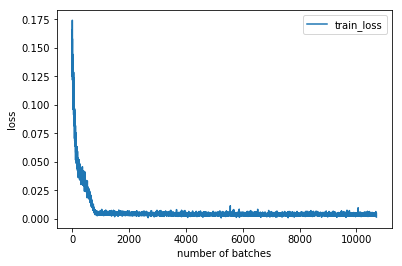

<Figure size 432x288 with 0 Axes>

In [8]:
#train_loss曲线  
x = np.linspace(0,len(train_log),len(train_log))  
plt.plot(x,train_log,label="train_loss",linewidth=1.5)  
plt.xlabel("number of batches")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('train_loss.jpg')  

### rmse、mae、mape的曲线图

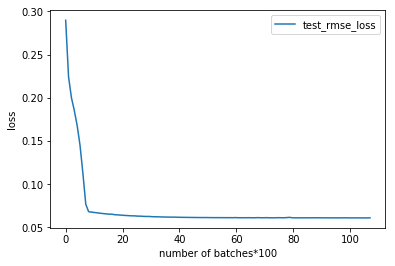

<Figure size 432x288 with 0 Axes>

In [9]:
#test_loss曲线  
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_rmse_loss.jpg')  

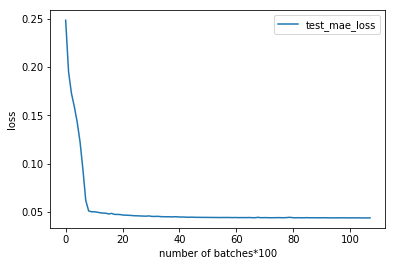

<Figure size 432x288 with 0 Axes>

In [10]:
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_mae_loss.jpg') 

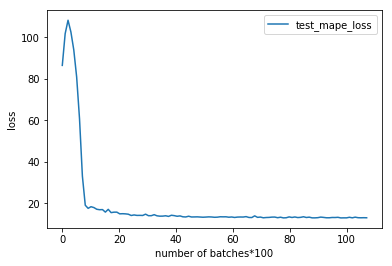

<Figure size 432x288 with 0 Axes>

In [11]:
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_mape_loss.jpg') 